In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_colwidth', 1000)



In [2]:
# escalated and non-escalated file names
file_paths = ['/Users/evgenyvasilets/Documents/UvA/internship_2/data/not_escalated.json', '/Users/evgenyvasilets/Documents/UvA/internship_2/data/escalated.json']
# create a list of dataframes
dfs = []
# create a single database
for idx, file in enumerate(file_paths):
    with open(file) as f:
        # Create a file with all escalated disputes
        data = json.load(f)
        # make a list of dictionaries that consist only of conversations
        conv_list = []
        for dispute in data:
            disp = dispute['conversation']
            conv_list.extend(disp)
        df = pd.DataFrame(conv_list)
        # The number of words in an utterance
        df['word_count'] = df['text'].str.count(' ') + 1
        # Whether the dispute was escalated (0 = not escalated, 1 = escalated) 
        df['escalated'] = idx
        # rename id to original id in df[1] (escalated)
        if idx == 1:
            df.rename(columns={"id": "original_id"}, inplace=True)
        dfs.append(df)
# Create a dataframe with both escalated and not escalated disputes
united_df = pd.concat(dfs)
def word_count_esc(df = united_df):
    for ind, val in enumerate(['not escalated:','escalated:']):
        print(val)
        print('Utterance num = ' + str(df[df.escalated == ind].original_id.nunique()))
        print('Dispute num = ' + str(df[df.escalated == ind].conv_id.nunique()) + '\n')
# word_count_esc()

# drop id column
united_df.drop(columns = ['id'], inplace = True)

The original dataset consists of 4441 utterances in escalated and 133019 utterances in non-escalated disputes. The number of disputes is 217 and 9006 repectively. 

count    137460.000000
mean         86.189481
std         163.104842
min           1.000000
25%          24.000000
50%          52.000000
75%         103.000000
max       17552.000000
Name: word_count, dtype: float64

Without long utterances:
not escalated:
Utterance num = 123712
Dispute num = 8768

escalated:
Utterance num = 4181
Dispute num = 208

user                string
original_id         string
time                string
type                string
reply_to            string
text                string
toxicity           float64
severe_toxicity    float64
conv_id             string
pagetitle           string
word_count           Int64
escalated            Int64
dtype: object

Without duplicates:
not escalated:
Utterance num = 123586
Dispute num = 8763

escalated:
Utterance num = 4055
Dispute num = 203

without no_reply
not escalated:
Utterance num = 25493
Dispute num = 2975

escalated:
Utterance num = 1726
Dispute num = 97



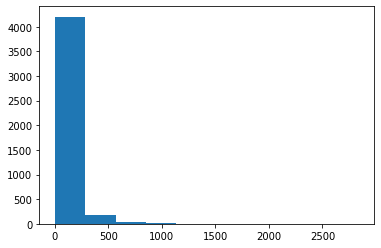

In [3]:
# Check how many disputes now have excluded utterances 
excluded = united_df[united_df.word_count > 1000]
plt.hist(united_df[united_df.escalated == 1].word_count)
print(united_df.word_count.describe())
# Delete from df all utterances that are longer than 1000 words
united_df_shortened = united_df[~united_df.isin(excluded)]
united_df_shortened.original_id.count()


# exclude conversations that have incomplete number of utterances
excluded_conv_id = excluded.conv_id.drop_duplicates()
united_df_shortened = united_df_shortened[~united_df_shortened.conv_id.isin(excluded_conv_id)]
# Check how many disputes and utterances are left
print('\nWithout long utterances:')
word_count_esc(united_df_shortened)

# Convert data to the best possible dtype
united_df_shortened = united_df_shortened.convert_dtypes()
print(united_df_shortened.dtypes)

# Delete duplicates (in both escalated and non-escalated datasets)
dub = united_df_shortened.original_id.duplicated() == True
df_dub = united_df_shortened[dub]
df_nodub = united_df_shortened[~united_df_shortened.conv_id.isin(df_dub.conv_id)]
print('\nWithout duplicates:')
word_count_esc(df_nodub)

# Assign the final version of the df
df = df_nodub

orig_indexes = df.original_id
reply_to_indexes = df.reply_to
reply_to_indexes = reply_to_indexes.dropna()

# Check whether any reply to id are not in orig ind
main_list = list(set(reply_to_indexes).difference(orig_indexes))
# delete all disputes which have reply_to indexes in the main list
to_remove = df[df.reply_to.isin(main_list)]
to_remove.head()
df_without_noreply = df[~df.conv_id.isin(to_remove.conv_id)]
print('without no_reply')
word_count_esc(df_without_noreply)

# Assign the final version of the df
df = df_without_noreply

# Set new index
df.set_index('original_id', inplace = True)

# Drop identical rows
df = df.drop_duplicates()

# Make self-replies a single utterance
for index, row in df.iterrows():
    # Make sure that this is a reply to a message
    if not type(row.reply_to) is str:
        continue
    if row.user == df.loc[row.reply_to].user:
        new_string = df.loc[row.reply_to].text + '\n' + row.text
        df.at[index, 'text'] = new_string
        df.at[row.reply_to, 'text'] = new_string

The mean number of words in an utterance is 86.19, the minimum is one and the maximum is 17552. As the data is extremely skewed, all utterances which word number was higher than the 1000, was excluded from the analysis. All disputes, that included utterances larger than 1000 words were also excluded from the dataset, as such disputes would lack sufficient data for the analysis.  The number of utterances in escalated and not escalated disputes was reduced to 4181 and 123712 respectively. The number of disputes is now equal to 208 and 8768 in escalated and not escalated datasets respectively. 

In [4]:
dic_dlgs = {'orig':[], 
           'reply':[], 
           'orig_id':[], 
           'reply_id':[], 
           'orig_user':[], 
           'reply_user':[], 
           'orig_toxicity':[], 
           'orig_severe_toxicity':[], 
           'reply_toxicity':[], 
           'reply_severe_toxicity':[],                   
           'conv_id':[], 
           'pagetitle':[], 
           'escalated':[]
            }

for index, reply_row in df.iterrows():
    # Make sure that this is a reply to a message
    if not type(reply_row.reply_to) is str:
        continue
    # This is the row with the original message
    orig_row = df.loc[reply_row.reply_to]
    # If this is a self-reply, make it a single utterance
    dic_dlgs['orig'].append(orig_row.text)
    dic_dlgs['reply'].append(reply_row.text) 
    dic_dlgs['orig_id'].append(orig_row.name)
    dic_dlgs['reply_id'].append(reply_row.name)
    dic_dlgs['reply_user'].append(reply_row.user)
    dic_dlgs['orig_user'].append(orig_row.user)
    dic_dlgs['orig_toxicity'].append(orig_row.toxicity)
    dic_dlgs['orig_severe_toxicity'].append(orig_row.severe_toxicity)
    dic_dlgs['reply_toxicity'].append(reply_row.toxicity)
    dic_dlgs['reply_severe_toxicity'].append(reply_row.severe_toxicity)
    dic_dlgs['conv_id'].append(reply_row.conv_id)
    dic_dlgs['escalated'].append(reply_row.escalated)
    dic_dlgs['pagetitle'].append(reply_row.pagetitle)
    
        
df_dlg = pd.DataFrame(dic_dlgs)
df_dlg.head()

# drop lines where reply and orig are identical (moderated self-replies)
df_dlg.drop(df_dlg[df_dlg.orig == df_dlg.reply].index, inplace = True)

# drop lines where authors of a reply and original mesages are the same 
df_dlg.drop(df_dlg[df_dlg.orig_user == df_dlg.reply_user].index, inplace = True)

# drop lines that were labled during the training session 
df_dlg.drop(df_dlg.loc[:204].index, inplace = True)

In [5]:
non_escalated = df_dlg[df_dlg.escalated == 0]
escalated = df_dlg[df_dlg.escalated == 1]
print(len(non_escalated))
print(len(escalated))

14419
1339


In [8]:
df = pd.concat([non_escalated, escalated])

In [10]:
df.groupby('conv_id')['orig'].count()

conv_id
10053262.421911.421911     3
10063456.0.0               4
10177313.14273.14273      11
10180335.27851.27851      24
102520933.17694.17694      2
                          ..
99878840.43446.43446       6
99880522.6412.6412         7
99902295.265.265           4
99929037.868.868           5
99959922.67638.67638       5
Name: orig, Length: 2930, dtype: int64

In [6]:
escalated.iloc[400:420].pagetitle

19983    Sugar (Maroon 5 song)
19984    Sugar (Maroon 5 song)
19985    Sugar (Maroon 5 song)
19986    Sugar (Maroon 5 song)
19987    Sugar (Maroon 5 song)
19988    Sugar (Maroon 5 song)
19989    Sugar (Maroon 5 song)
19990    Sugar (Maroon 5 song)
19991    Sugar (Maroon 5 song)
19992    Sugar (Maroon 5 song)
19993    Sugar (Maroon 5 song)
19994    Sugar (Maroon 5 song)
19996                Johnnie2u
19997                Johnnie2u
19998                Johnnie2u
19999                Johnnie2u
20000                Johnnie2u
20001                Johnnie2u
20002                Johnnie2u
20003                Johnnie2u
Name: pagetitle, dtype: object

In [7]:

tijs_non_escalated = non_escalated.loc[:1547]
tijs_escalated = escalated.loc[:19994]
Tijs = pd.concat([tijs_non_escalated, tijs_escalated])


In [8]:
left = df_dlg.drop(df_dlg[df_dlg.index.isin(Tijs.index)].index)
display(left[left.escalated == 0].iloc[1700:1710].pagetitle)
Evgeny_not_escalated = left[left.escalated == 0].loc[:3824]
Evgeny_escalated = left[left.escalated == 1].iloc[:-1]

print(len(Evgeny_not_escalated))
print(len(Evgeny_escalated))
Evgeny = pd.concat([Evgeny_not_escalated, Evgeny_escalated, tijs_non_escalated.iloc[:100], tijs_escalated.iloc[:100]])

3815    George W. Bush
3816    George W. Bush
3818     Islamofascism
3819     Islamofascism
3820     Islamofascism
3821     Islamofascism
3822     Islamofascism
3823     Islamofascism
3824     Islamofascism
3826         Tom DeLay
Name: pagetitle, dtype: object

1709
926


In [9]:
print(len(Evgeny))
print(len(Tijs))

2835
1413


In [10]:
# # Make utterences where a user answers to themselves in a subsequent message a single utterance. 
# # All answers to any of these utterances should be considered as answers to the newly created utterance. 
# actual_df = df_dlg.copy()

 
# # Firstly, unite the utterances. 
# for index, row in actual_df.iterrows(): 
#     if row.orig_user == row.reply_user:
#         new_string = row.orig + '\n' + row.reply
#         actual_df.at[index, 'orig'] = new_string
#         actual_df.at[index, 'reply'] = new_string


In [11]:
# df_dlg.to_excel('dialogues_v2.xlsx')

In [12]:
# Evgeny.to_excel('dialogues_v3_Evgeny.xlsx')
# Tijs.to_excel('dialogues_v3_Tijs.xlsx')

In [23]:
united_df[(united_df.pagetitle == 'Muhammad Ali') & (united_df.word_count == 192)]

,user,original_id,time,type,reply_to,text,toxicity,severe_toxicity,conv_id,pagetitle,word_count,escalated
1110,Per Abrahamsen,103002793.17970.17970,2007-01-24 22:20:04,modification,102988832.9898.9898,"(I don't know about the libel.) The claim ""Sunni Muslim philosophy contributes to his belief in segregation"" does not obviously follow from the cited article. The article text is not very clear, and the phrases ""segregation"" and ""Sunni Muslim"" does not appear. One might guess from the anecdotes told in the article that MA believes in segregation, but it is not directly stated anywhere. And there might be a connection between that belief and his Black Muslim connection, again it is not especially clear from the text alone. The jump from ""Black Muslim"" to ""Sunni Muslim philosophy"" as a reason is not supported at all.\nEven if MA believes in segregation, it is a question if that fact is of encyclopedic value. If the SI quote is the strongest statements for segregation he has made, it hasn't. It is only encyclopedic, if it is part of his public persona. If it is, the best bet would be to mention any segregation activities in the section talking about his Nation of Islam involve...",0.071113,0.01522,102988832.9898.9898,Muhammad Ali,192,0
1123,Chrislk02,116540191.9823.0,2007-03-20 15:12:30,original,102988832.9898.9898,"(I don't know about the libel.) The claim ""Sunni Muslim philosophy contributes to his belief in segregation"" does not obviously follow from the cited article. The article text is not very clear, and the phrases ""segregation"" and ""Sunni Muslim"" does not appear. One might guess from the anecdotes told in the article that MA believes in segregation, but it is not directly stated anywhere. And there might be a connection between that belief and his Black Muslim connection, again it is not especially clear from the text alone. The jump from ""Black Muslim"" to ""Sunni Muslim philosophy"" as a reason is not supported at all.\nEven if MA believes in segregation, it is a question if that fact is of encyclopedic value. If the SI quote is the strongest statements for segregation he has made, it hasn't. It is only encyclopedic, if it is part of his public persona. If it is, the best bet would be to mention any segregation activities in the section talking about his Nation of Islam involve...",0.071113,0.01522,102988832.9898.9898,Muhammad Ali,192,0
1126,Wimt,124322688.9824.0,2007-04-20 10:58:12,original,102988832.9898.9898,"(I don't know about the libel.) The claim ""Sunni Muslim philosophy contributes to his belief in segregation"" does not obviously follow from the cited article. The article text is not very clear, and the phrases ""segregation"" and ""Sunni Muslim"" does not appear. One might guess from the anecdotes told in the article that MA believes in segregation, but it is not directly stated anywhere. And there might be a connection between that belief and his Black Muslim connection, again it is not especially clear from the text alone. The jump from ""Black Muslim"" to ""Sunni Muslim philosophy"" as a reason is not supported at all.\nEven if MA believes in segregation, it is a question if that fact is of encyclopedic value. If the SI quote is the strongest statements for segregation he has made, it hasn't. It is only encyclopedic, if it is part of his public persona. If it is, the best bet would be to mention any segregation activities in the section talking about his Nation of Islam involve...",0.071113,0.01522,102988832.9898.9898,Muhammad Ali,192,0
1129,Garion96,132965070.9879.0,2007-05-23 17:49:17,original,102988832.9898.9898,"(I don't know about the libel.) The claim ""Sunni Muslim philosophy contributes to his belief in segregation"" does not obviously follow from the cited article. The article text is not very clear, and the phrases ""segregation"" and ""Sunni Muslim"" does not appear. One might guess from the anecdotes told in the article that MA believes in segregation, but it is not directly sta

In [16]:
matrix = [[1, 2, 3], [4, 5, 6], [7, 8, 9]]

In [17]:
def sled(mat):
    counter = 0
    sled = 0
    for row in mat:
        sled = sled + row[counter]
        counter+=1
    return sled
sled(matrix)

15